In [1]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import tensorflow.keras
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix

2023-04-24 11:23:46.108178: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-24 11:23:46.108197: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
allData = pd.read_csv('../feature_data/features.csv')
allData.replace([np.inf, -np.inf], np.nan, inplace=True)
allData = allData.dropna()
X = allData.drop(["label"],axis=1)
X = X.drop(["radius"],axis=1)
cols = X.keys()

#normalize data
#X = preprocessing.normalize(X, norm='max')

#labels
y = allData["label"]

#features
X = pd.DataFrame(X, columns = cols)

In [3]:
X.describe()

,num_points,std,avg_median_dev,width,linearity,circularity,boundary_length,boundary_regularity,mean_curvature,ang_diff,iav,std_iav,distance,dist_num_points,occluded_right,occluded_left
count,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9.489000e+03,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000,9489.000000
mean,17.307936,0.145534,0.123339,0.442383,19.646191,1.498107e-01,0.534513,0.017417,19.784566,2.237601,2.627493,1.561736,2.957513,0.440747,0.783644,0.722942
std,27.506733,0.233990,0.205220,0.791545,158.022617,1.136570e+00,0.933008,0.012034,18.819969,0.623728,0.718840,0.519241,1.900385,0.528611,0.411781,0.447569
min,3.000000,0.008048,0.005680,0.012648,0.000076,8.969470e-16,0.017039,0.002987,0.045276,0.186256,0.421913,0.273109,0.289371,0.002502,0.000000,0.000000
25%,6.000000,0.038555,0.031740,0.101891,0.006914,1.677530e-04,0.130319,0.008200,5.679890,1.890190,2.219300,1.202750,1.478220,0.101666,1.000000,0.000000
50%,9.000000,0.056707,0.045411,0.144635,0.025590,8.454680e-04,0.195660,0.013237,13.218500,2.376490,2.777150,1.578390,2.345690,0.244998,1.000000,1.000000
75%,17.000000,0.134151,0.118170,0.380985,0.823912,5.842730e-03,0.525086,0.024435,28.153900,2.733730,3.127850,1.915240,4.034960,0.561094,1.000000,1.000000
max,279.000000,3.033200,2.481590,12.762600,3971.650000,2.965000e+01,12.889000,0.072851,123.093000,3.127740,4.565440,3.304990,7.458060,2.482980,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
(949, 16)


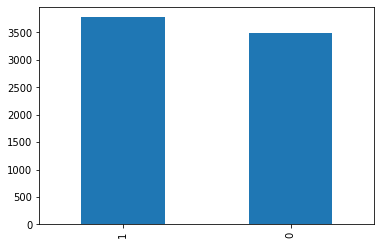

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)
print(type(X_test))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=5)
y_train.value_counts().plot.bar()

print(X_test.shape)
#oversample the minority
y_train.value_counts().plot.bar()

ros = RandomOverSampler(sampling_strategy="minority", random_state=5)
#X_train, y_train = ros.fit_resample(X_train, y_train)

#y_train.value_counts().plot.bar()
#y_test.value_counts().plot.bar()

In [5]:
# originally saved version

def NN_Model(units = 32, dropout=0.2, optimizer = 'adam'):
    model = models.Sequential()
    model.add(tensorflow.keras.Input(shape=(16,)))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(layers.Dense(units = units, activation='leaky_relu',))

    model.add(layers.Dense(units = units, activation='leaky_relu',))
    
    model.add(layers.Dense(units = units, activation='leaky_relu'))

    #model.add(layers.Dense(units = units, activation='leaky_relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model
    

In [46]:
# test 1
def NN_Model(units = 32):
    model = models.Sequential()
    model.add(tensorflow.keras.Input(shape=(16,)))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(layers.Dense(units = units, activation='leaky_relu',))

    model.add(layers.Dense(units = units, activation='leaky_relu'))

    model.add(layers.Dense(units = units*2, activation='leaky_relu',))
    
    model.add(layers.Dense(units = units*4, activation='leaky_relu'))


    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [20]:
# test 2
def NN_Model(units = 32):
    model = models.Sequential()
    model.add(tensorflow.keras.Input(shape=(16,)))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(layers.Dense(units = units, activation='leaky_relu',))

    model.add(layers.Dense(units = units, activation='leaky_relu',))

    model.add(layers.Dense(units = units*2, activation='leaky_relu',))
    
    model.add(layers.Dense(units = units*4, activation='leaky_relu'))

    #model.add(layers.Dense(units = units, activation='leaky_relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [52]:
ms = []
hs = []
for f in [32,64]:
    #for d in [0.15,0.2,0.25,0.3]:
    #    if (f == 32 and d == 0.2) or (f==64 and d==0.15) or (f==96 and d!=0.2):
    model = NN_Model(units=f)
    model.summary()
    ms.append(model)
    history = model.fit(X_train, y_train, epochs=150, 
                    validation_data=(X_val, y_val))
    loc = "../models/NN_test_"+str(f)+".h5"
    model.save(loc)
    hs.append(history)


Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_45 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dense_193 (Dense)           (None, 32)                544       
                                                                 
 dense_194 (Dense)           (None, 32)                1056      
                                                                 
 dense_195 (Dense)           (None, 64)                2112      
                                                                 
 dense_196 (Dense)           (None, 128)               8320      
                                                                 
 dense_197 (Dense)           (None, 1)                 129       
                                                     

227/227 [==============================] - 1s 2ms/step - loss: 0.0977 - accuracy: 0.9605 - val_loss: 0.0961 - val_accuracy: 0.9688
Epoch 50/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1009 - accuracy: 0.9581 - val_loss: 0.0956 - val_accuracy: 0.9703
Epoch 51/150
227/227 [==============================] - 1s 2ms/step - loss: 0.1010 - accuracy: 0.9583 - val_loss: 0.0974 - val_accuracy: 0.9672
Epoch 52/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0939 - accuracy: 0.9607 - val_loss: 0.1041 - val_accuracy: 0.9664
Epoch 53/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0947 - accuracy: 0.9618 - val_loss: 0.0897 - val_accuracy: 0.9696
Epoch 54/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0974 - accuracy: 0.9614 - val_loss: 0.0897 - val_accuracy: 0.9703
Epoch 55/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0982 - accuracy: 0.9587 - val_loss: 0.0944 - val_accuracy: 0.9680
Epoch

Epoch 106/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0831 - accuracy: 0.9647 - val_loss: 0.0848 - val_accuracy: 0.9703
Epoch 107/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0839 - accuracy: 0.9661 - val_loss: 0.0872 - val_accuracy: 0.9703
Epoch 108/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0814 - accuracy: 0.9683 - val_loss: 0.0939 - val_accuracy: 0.9672
Epoch 109/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0816 - accuracy: 0.9679 - val_loss: 0.0990 - val_accuracy: 0.9664
Epoch 110/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0901 - accuracy: 0.9640 - val_loss: 0.0871 - val_accuracy: 0.9680
Epoch 111/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0841 - accuracy: 0.9649 - val_loss: 0.0933 - val_accuracy: 0.9641
Epoch 112/150
227/227 [==============================] - 1s 2ms/step - loss: 0.0807 - accuracy: 0.9665 - val_loss: 0.0940 - val_ac

Epoch 4/150
227/227 [==============================] - 1s 3ms/step - loss: 0.1288 - accuracy: 0.9457 - val_loss: 0.0993 - val_accuracy: 0.9594
Epoch 5/150
227/227 [==============================] - 1s 3ms/step - loss: 0.1276 - accuracy: 0.9450 - val_loss: 0.0990 - val_accuracy: 0.9617
Epoch 6/150
227/227 [==============================] - 1s 3ms/step - loss: 0.1182 - accuracy: 0.9501 - val_loss: 0.1003 - val_accuracy: 0.9641
Epoch 7/150
227/227 [==============================] - 1s 3ms/step - loss: 0.1174 - accuracy: 0.9489 - val_loss: 0.0972 - val_accuracy: 0.9602
Epoch 8/150
227/227 [==============================] - 1s 3ms/step - loss: 0.1162 - accuracy: 0.9488 - val_loss: 0.0965 - val_accuracy: 0.9617
Epoch 9/150
227/227 [==============================] - 1s 3ms/step - loss: 0.1218 - accuracy: 0.9482 - val_loss: 0.1005 - val_accuracy: 0.9610
Epoch 10/150
227/227 [==============================] - 1s 3ms/step - loss: 0.1116 - accuracy: 0.9525 - val_loss: 0.1064 - val_accuracy: 0.956

Epoch 61/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0934 - accuracy: 0.9632 - val_loss: 0.0903 - val_accuracy: 0.9657
Epoch 62/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0823 - accuracy: 0.9667 - val_loss: 0.0978 - val_accuracy: 0.9680
Epoch 63/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0869 - accuracy: 0.9651 - val_loss: 0.0873 - val_accuracy: 0.9680
Epoch 64/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0873 - accuracy: 0.9645 - val_loss: 0.0950 - val_accuracy: 0.9688
Epoch 65/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0916 - accuracy: 0.9632 - val_loss: 0.0842 - val_accuracy: 0.9672
Epoch 66/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0857 - accuracy: 0.9634 - val_loss: 0.0830 - val_accuracy: 0.9727
Epoch 67/150
227/227 [==============================] - 1s 3ms/step - loss: 0.0931 - accuracy: 0.9634 - val_loss: 0.0975 - val_accuracy:

Epoch 118/150
227/227 [==============================] - 1s 4ms/step - loss: 0.0806 - accuracy: 0.9689 - val_loss: 0.0961 - val_accuracy: 0.9711
Epoch 119/150
227/227 [==============================] - 1s 4ms/step - loss: 0.0760 - accuracy: 0.9704 - val_loss: 0.0973 - val_accuracy: 0.9664
Epoch 120/150
227/227 [==============================] - 1s 5ms/step - loss: 0.0761 - accuracy: 0.9698 - val_loss: 0.1000 - val_accuracy: 0.9664
Epoch 121/150
227/227 [==============================] - 1s 4ms/step - loss: 0.0838 - accuracy: 0.9658 - val_loss: 0.0955 - val_accuracy: 0.9703
Epoch 122/150
227/227 [==============================] - 1s 4ms/step - loss: 0.0780 - accuracy: 0.9696 - val_loss: 0.0864 - val_accuracy: 0.9688
Epoch 123/150
227/227 [==============================] - 1s 4ms/step - loss: 0.0807 - accuracy: 0.9687 - val_loss: 0.0864 - val_accuracy: 0.9727
Epoch 124/150
227/227 [==============================] - 1s 4ms/step - loss: 0.0772 - accuracy: 0.9694 - val_loss: 0.0923 - val_ac

30/30 - 0s - loss: 0.0905 - accuracy: 0.9737 - 54ms/epoch - 2ms/step
Test Loss: 0.09051389247179031
Test Accuracy: 0.9736564755439758


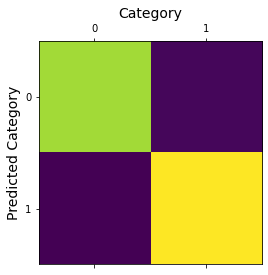

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       436
           1       0.98      0.97      0.98       513

    accuracy                           0.97       949
   macro avg       0.97      0.97      0.97       949
weighted avg       0.97      0.97      0.97       949

30/30 - 0s - loss: 0.0894 - accuracy: 0.9684 - 57ms/epoch - 2ms/step
Test Loss: 0.08940307796001434
Test Accuracy: 0.9683877825737


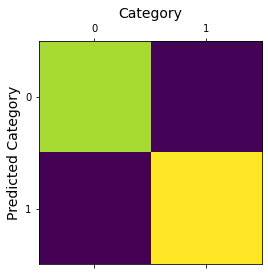

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       441
           1       0.97      0.97      0.97       508

    accuracy                           0.97       949
   macro avg       0.97      0.97      0.97       949
weighted avg       0.97      0.97      0.97       949



In [53]:
for m in ms:
    test_loss, test_acc = m.evaluate(X_test,  y_test, verbose=2)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_acc)
    y_pred = m.predict(X_test)
    a = []
    for x in y_pred:
        a.append(1 if x[0] > 0.5 else 0)
    y_pred = pd.Series(a)
    plt.matshow(confusion_matrix(y_test, y_pred, labels=[0,1]))
    plt.ylabel("Predicted Category", fontsize=14)
    plt.title("Category", fontsize=14)
    plt.show()
    print(classification_report(y_pred,y_test))

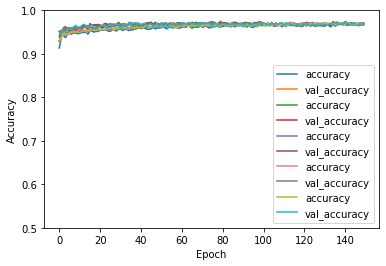

In [8]:
for i in range(len(hs)):
    plt.plot(hs[i].history['accuracy'], label='accuracy')
    plt.plot(hs[i].history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
